# LAB 8 : Classification

  1. Support Vector Machines 
  2. K-Nearest Neighbors
  3. Classification on MNIST Digit 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math

# Support Vector Machines (SVM)



1. Try to maximize the margin of separation between data.
2. Instead of learning wx+b=0  separating hyperplane directly (like logistic regression), SVM try to learn wx+b=0, such that, the margin between two hyperplanes wx+b=1 and wx+b=-1 (also known as support vectors) is maximum. 
3. Margin between wx+b=1 and wx+b=-1 hyperplane is $\frac{2}{||w||}$
4. we have a constraint optimization problem of maximizing $\frac{2}{||w||}$, with constraints wx+b>=1 (for +ve class) and wx+b<=-1 (for -ve class).
5. As $y_{i}=1$ for +ve class and $y_{i}=-1$ for -ve class, the constraint can be re-written as:
$$y(wx+b)>=1$$

6. Final optimization is (i.e to find w and b):
$$\min_{||w||}\frac{1}{2}||w||,$$
$$y(wx+b) \geq 1,~\forall ~data $$



Acknowledgement:

https://pythonprogramming.net/predictions-svm-machine-learning-tutorial/

https://medium.com/deep-math-machine-learning-ai/chapter-3-1-svm-from-scratch-in-python-86f93f853dc

## Data generation:
1. Generate 2D gaussian data with fixed mean and variance for 2 class.(var=Identity, class1: mean[-4,-4], class2: mean[1,1], No. of data 25 from each class)
2. create the label matrix
3. Plot the generated data

(50, 2)
(50,)


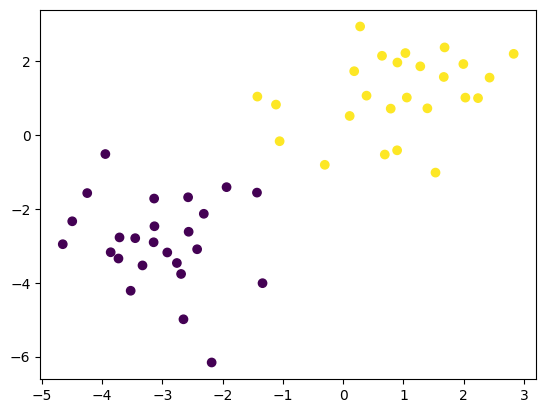

In [72]:
No_sample=50
mean1=np.array([-3,-3])
var1=np.array([[1,0],[0,1]])
mean2=np.array([1,1])
var2=var1
data1=np.random.multivariate_normal(mean1,var1,int(No_sample/2))
data2=np.random.multivariate_normal(mean2,var2,int(No_sample/2))
X=np.concatenate((data1,data2))
print(X.shape)
y=np.concatenate((-1*np.ones(data1.shape[0]),np.ones(data2.shape[0])))
print(y.shape)

plt.figure()
plt.scatter(X[:,0],X[:,1],marker='o',c=y)

Create a data dictionary, which contains both label and data points.

In [73]:
postiveX=[]
negativeX=[]
for i,v in enumerate(y):
    if v==-1:
        negativeX.append(X[i])
    else:
        postiveX.append(X[i])

#our data dictionary
data_dict = {-1:np.array(negativeX), 1:np.array(postiveX)} 

## SVM training
1. create a search space for w (i.e w1=w2),[0, 0.5*max((abs(feat)))] and  for b, [-max((abs(feat))),max((abs(feat)))], with appropriate step.
2. we will start with a higher step and find optimal w and b, then we will reduce the step and again re-evaluate the optimal one.

3. In each step, we will take transform of w, [1,1], [-1,1],[1,-1] and [-1,-1] to search arround the w. 

4. In every pass (for a fixed step size) we will store all the w, b and its corresponding ||w||, which make the data correctly classified as per the condition $y(wx+b) \geq 1$. 

5. Obtain the optimal hyperplane having minimum ||w||.

6. Start with the optimal w and repeat the same (step 3,4 and 5) for a reduced step size.


In [74]:
class SVM:
    def __init__(self, data_dict) -> None:
        self.data_dict = data_dict
        self.w = []
        self.b = []
        self.max_feature_value=float('-inf')
        self.min_feature_value=float('+inf')
        self._min_max_fv(data_dict)
        self.learning_rate = [self.max_feature_value * 0.1, self.max_feature_value * 0.01, self.max_feature_value * 0.001,]

    def _min_max_fv(self, data_dict):
        for yi in data_dict:
            if np.amax(data_dict[yi])>self.max_feature_value:
                self.max_feature_value=np.amax(data_dict[yi])
                
            if np.amin(data_dict[yi])<self.min_feature_value:
                self.min_feature_value=np.amin(data_dict[yi])

    def train(self, data_dict):
        i=1
        w = []
        b = []
    
        length_Wvector = {}
        transforms = [[1,1],[-1,1],[-1,-1],[1,-1]]
    
        b_step_size = 2
        b_multiple = 5
        w_optimum = self.max_feature_value*0.5

        for lrate in self.learning_rate:
        
            w = np.array([w_optimum,w_optimum])     
            optimized = False
            while not optimized:
            
                for b in np.arange(-1*(self.max_feature_value*b_step_size), self.max_feature_value*b_step_size, lrate*b_multiple):
                    for transformation in transforms:  
                        w_t = w*transformation
                    
                        correctly_classified = True
                    
                    
                        for yi in data_dict:
                            for xi in data_dict[yi]:
                                if yi*(np.dot(w_t,xi)+b) < 1:  # we want  yi*(np.dot(w_t,xi)+b) >= 1 for correct classification
                                    correctly_classified = False
                                
                        if correctly_classified:
                            length_Wvector[np.linalg.norm(w_t)] = [w_t,b] #store w, b for minimum magnitude
            
                if w[0] < 0:
                    optimized = True
                else:
                    w = w - lrate

            norms = sorted([n for n in length_Wvector])
        
            minimum_wlength = length_Wvector[norms[0]]
            w = minimum_wlength[0]
            b = minimum_wlength[1]
        
            w_optimum = w[0]+lrate*2
            
        self.w = w
        self.b = b

        return w,b
        


**Training**

In [76]:
# All the required variables 
w=[] # Weights 2 dimensional vector
b=[] # Bias
SVC = SVM(data_dict)
w,b = SVC.train(data_dict)
print(w)
print(b)

[1.13430719 1.13430719]
2.3864644737226968


## Visualization of the SVM separating hyperplanes (after training)

In [77]:
def visualize(data_dict):
       
        
        plt.scatter(X[:,0],X[:,1],marker='o',c=y)

        # hyperplane = x.w+b
        # v = x.w+b
        # psv = 1
        # nsv = -1
        # dec = 0
        def hyperplane_value(x,w,b,v):
            return (-w[0]*x-b+v) / w[1]

        
        hyp_x_min = np.min([np.min(data_dict[1]),np.min(data_dict[-1])])
        hyp_x_max = np.max([np.max(data_dict[1]),np.max(data_dict[-1])])

        # (w.x+b) = 1
        # positive support vector hyperplane
        psv1 = hyperplane_value(hyp_x_min, w, b, 1)
        psv2 = hyperplane_value(hyp_x_max, w, b, 1)
        plt.plot([hyp_x_min,hyp_x_max],[psv1,psv2], 'k')

        # (w.x+b) = -1
        # negative support vector hyperplane
        nsv1 = hyperplane_value(hyp_x_min, w, b, -1)
        nsv2 = hyperplane_value(hyp_x_max, w, b, -1)
        plt.plot([hyp_x_min,hyp_x_max],[nsv1,nsv2], 'k')

        # (w.x+b) = 0
        # positive support vector hyperplane
        db1 = hyperplane_value(hyp_x_min, w, b, 0)
        db2 = hyperplane_value(hyp_x_max, w, b, 0)
        plt.plot([hyp_x_min,hyp_x_max],[db1,db2], 'y--')
        
        
        

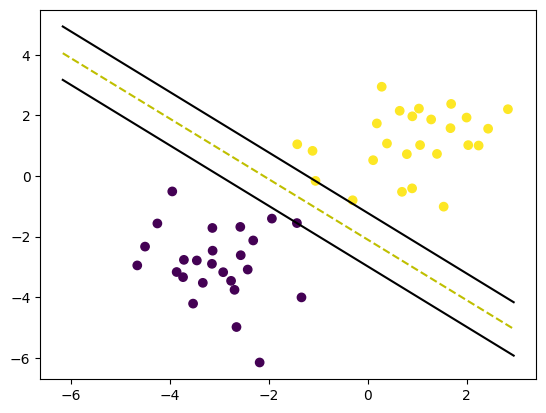

In [78]:
fig = plt.figure()
visualize(data_dict)

**Testing**

In [79]:
def predict(data,w,b):
  y_pred=np.sign(np.dot(data,w)+b)
  return y_pred

test accuracy= 100.0


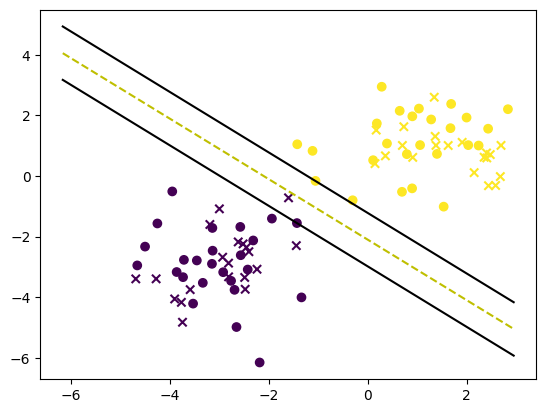

In [80]:
No_test_sample=40
data1=np.random.multivariate_normal(mean1,var1,int(No_test_sample/2))
data2=np.random.multivariate_normal(mean2,var2,int(No_test_sample/2))
test_data=np.concatenate((data1,data2))
y_gr=np.concatenate((-1*np.ones(data1.shape[0]),np.ones(data2.shape[0])))

# evaluate with the trained model

y_pred=predict(test_data,w,b)
accuracy=(1-(np.abs(0.5*np.sum(y_pred-y_gr))/y_pred.shape[0]))*100
print('test accuracy=',accuracy)

#  Visualization
plt.figure()
visualize(data_dict)
plt.scatter(test_data[:,0],test_data[:,1],marker='x',c=y_gr)


**Use the Sci-kit Learn Package and perform Classification on the above dataset using the SVM algorithm**

In [81]:
from sklearn.svm import LinearSVC
svm = LinearSVC()
svm.fit(X,y)
tr_Acc = svm.score(X,y)
print('Train accuracy SVM =',tr_Acc*100)

Train accuracy SVM = 100.0


In [82]:
# svm testing
from sklearn.metrics import confusion_matrix as conf_mat
y_pred=svm.predict(test_data)
svm_Acc=svm.score(test_data,y_gr)
print('Test accuracy SVM=',svm_Acc*100)
print('Confusion matrix=\n',conf_mat(y_gr,y_pred))

Test accuracy SVM= 100.0
Confusion matrix=
 [[20  0]
 [ 0 20]]


# K-Nearest Neighbours (KNN)

Text(0.5, 1.0, 'Data visualization')

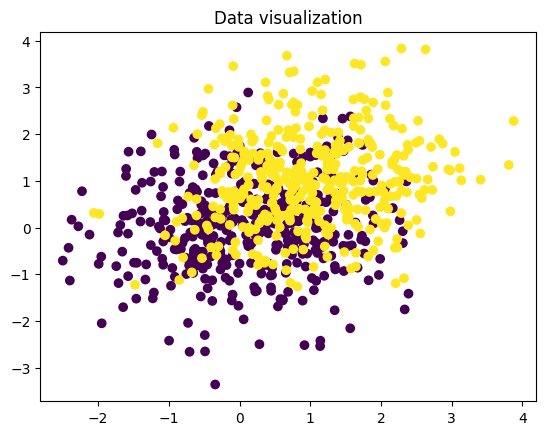

In [83]:
import numpy as np
import matplotlib.pyplot as plt

mean1=np.array([0,0])
mean2=np.array([1,1])
var=np.array([[1,0.1],[0.1,1]])
np.random.seed(0)
data1=np.random.multivariate_normal(mean1,var,500)
data2=np.random.multivariate_normal(mean2,var,500)
data_train=np.concatenate((data1[:-100,],data2[:-100]))
label=np.concatenate((np.zeros(data1.shape[0]-100),np.ones(data2.shape[0]-100)))

plt.figure()
plt.scatter(data_train[:,0],data_train[:,1],c=label)
plt.title('Data visualization')

In [84]:
def euclidean_distance(row1, row2):
  return np.linalg.norm(row1-row2)

In [85]:
def get_neighbors(train,label_train, test_row, num_neighbors):
  distances = list()
  for i in range(train.shape[0]):
    train_row=train[i,:]
    label_row=label_train[i]
    dist = euclidean_distance(test_row, train_row)
    distances.append((train_row, dist,label_row))
  distances.sort(key=lambda tup: tup[1])
  neighbors = list()
  for i in range(num_neighbors):
    neighbors.append(distances[i])
  return neighbors

In [86]:
def predict_classification(neigbors):
  pred=list()
  for i in range(len(neigbors)):
    pred.append(neigbors[i][2])
  prediction = max(set(pred), key=pred.count)
  return prediction

In [87]:

data_test=np.concatenate((data1[-100:],data2[-100:]))
label_test=np.concatenate((np.zeros(100),np.ones(100)))

In [88]:
K=2

pred_label=np.zeros(data_test.shape[0])
for i in range(data_test.shape[0]):
  neig=get_neighbors(data_train,label, data_test[i,:], K)
  pred_label[i]=predict_classification(neig)

accuracy=(len(np.where(pred_label==label_test)[0])/len(label_test))*100
print('Testing Accuracy=',accuracy,'%')

Testing Accuracy= 65.5 %


**Use the Sci-kit Learn Package and perform Classification on the above dataset using the K-Nearest Neighbour algorithm**

In [89]:
from sklearn.neighbors import KNeighborsClassifier
model = KNeighborsClassifier(n_neighbors=2)
model.fit(data_train,label)
pred_label = model.predict(data_test)

accuracy=(len(np.where(pred_label==label_test)[0])/len(label_test))*100
print('Testing Accuracy=',accuracy,'%')

Testing Accuracy= 65.5 %


# Classification on MNIST Digit Data

1. Read MNIST data and perform train-test split
2. Select any 2 Classes and perform classification task using SVM, KNN and Logistic Regression algorithms with the help of Sci-Kit Learn tool
3. Report the train and test accuracy and also display the results using confusion matrix
4. Repeat steps 2 and 3 for all 10 Classes and tabulate the results

In [90]:

%pip install idx2numpy

Defaulting to user installation because normal site-packages is not writeable
distutils: /home/abhishekj/.local/lib/python3.9/site-packages
sysconfig: /home/abhishekj/.local/lib64/python3.9/site-packages
user = True
home = None
root = None
prefix = None
You should consider upgrading via the '/bin/python -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [91]:
import numpy as np
import matplotlib.pyplot as plt 
from sklearn.utils import shuffle


file1='./t10k-images-idx3-ubyte'
file2='./t10k-labels-idx1-ubyte'

import idx2numpy


x_train= idx2numpy.convert_from_file(file1)
y_train= idx2numpy.convert_from_file(file2)

In [92]:
print(x_train.shape)
print(y_train.shape)

(10000, 28, 28)
(10000,)


In [93]:
indx1 = np.where(y_train == 1)[0]

indx4 = np.where(y_train == 4)[0]

In [94]:
x1 = x_train[indx1]
x4 = x_train[indx4]

y1 = y_train[indx1]
y2 = y_train[indx4]

In [95]:
X = []
for x in x1:
    X.append([x.flatten()])
for x in x4:
    X.append([x.flatten()])
X = np.concatenate(X)
print(X.shape)

Y = np.concatenate((y1,y2))
print(Y.shape)

(2117, 784)
(2117,)


In [96]:
from PIL import Image
for im in x1[:5]:
    img = Image.fromarray(im)
    img.show()
for im in x4[:5]:
    img = Image.fromarray(im)
    img.show()

In [97]:
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline


In [98]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix 

X_tr, X_tst, Y_tr, Y_tst = train_test_split(X,Y)

# SVM

In [99]:
clf = make_pipeline(StandardScaler(), SVC())
clf.fit(X=X_tr,y=Y_tr)
print(f"Train accuracy is {clf.score(X_tr,Y_tr)}")
y_pred = clf.predict(X_tst)
print(f"Accuracy of this model is {accuracy_score(Y_tst,y_pred)*100}%")
confusion_matrix(Y_tst,y_pred)

Test accuracy is 1.0
Accuracy of this model is 99.05660377358491%


array([[274,   4],
       [  1, 251]])

# Logistic


In [100]:
clf = make_pipeline(StandardScaler(), LogisticRegression())
clf.fit(X=X_tr,y=Y_tr)
print(f"Test accuracy is {clf.score(X_tr,Y_tr)}")
y_pred = clf.predict(X_tst)
print(f"Accuracy of this model is {accuracy_score(Y_tst,y_pred)*100}%")
confusion_matrix(Y_tst,y_pred)

Test accuracy is 1.0
Accuracy of this model is 99.62264150943396%


array([[277,   1],
       [  1, 251]])

# Knn

In [101]:
clf = make_pipeline(StandardScaler(), KNeighborsClassifier())
clf.fit(X=X_tr,y=Y_tr)
print(f"Test accuracy is {clf.score(X_tr,Y_tr)}")
y_pred = clf.predict(X_tst)
print(f"Accuracy of this model is {accuracy_score(Y_tst,y_pred)*100}%")
confusion_matrix(Y_tst,y_pred)

Test accuracy is 0.9949590422180214
Accuracy of this model is 97.73584905660377%


array([[277,   1],
       [ 11, 241]])

# All 10 classes

## Test train split

In [102]:
file1='./t10k-images-idx3-ubyte'
file2='./t10k-labels-idx1-ubyte'

import idx2numpy


x_train= idx2numpy.convert_from_file(file1)
y_train= idx2numpy.convert_from_file(file2)

X = []
Y = []

for x in x_train:
    X.append([x.flatten()])

X = np.concatenate(X)
print(X.shape)

Y = y_train
print(Y.shape)

X_tr, X_tst, Y_tr, Y_tst = train_test_split(X,Y)

(10000, 784)
(10000,)


# SVM

In [103]:
clf = make_pipeline(StandardScaler(), SVC())
clf.fit(X=X_tr,y=Y_tr)
print(f"Test accuracy is {clf.score(X_tr,Y_tr)}")
y_pred = clf.predict(X_tst)
print(f"Accuracy of this model is {accuracy_score(Y_tst,y_pred)*100}%")
confusion_matrix(Y_tst,y_pred)

Test accuracy is 0.9857333333333334
Accuracy of this model is 92.92%


array([[240,   0,   6,   0,   0,   1,   3,   0,   1,   0],
       [  0, 264,   3,   0,   0,   0,   1,   0,   0,   0],
       [  2,   0, 257,   1,   1,   0,   1,   5,   4,   0],
       [  0,   0,   9, 232,   0,   3,   0,   3,   6,   2],
       [  1,   0,   7,   0, 236,   0,   2,   1,   1,   3],
       [  2,   0,   6,   8,   4, 193,   3,   3,   5,   1],
       [  1,   0,  10,   0,   1,   3, 247,   0,   0,   0],
       [  0,   4,   9,   1,   1,   0,   0, 235,   0,   4],
       [  0,   1,   4,   3,   2,   4,   2,   0, 204,   3],
       [  1,   0,  10,   1,   5,   0,   0,   5,   3, 215]])

# Logistic

In [104]:
clf = make_pipeline(StandardScaler(), LogisticRegression())
clf.fit(X=X_tr,y=Y_tr)
print(f"Test accuracy is {clf.score(X_tr,Y_tr)}")
y_pred = clf.predict(X_tst)
print(f"Accuracy of this model is {accuracy_score(Y_tst,y_pred)*100}%")
confusion_matrix(Y_tst,y_pred)

Test accuracy is 1.0
Accuracy of this model is 89.8%


/home/abhishekj/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


array([[244,   0,   2,   0,   1,   1,   2,   0,   1,   0],
       [  0, 257,   1,   0,   0,   2,   0,   0,   8,   0],
       [  2,   1, 240,   5,   4,   1,   2,   7,   6,   3],
       [  0,   2,   6, 221,   0,  14,   0,   5,   2,   5],
       [  1,   0,   3,   0, 224,   0,   5,   4,   2,  12],
       [  4,   0,   2,   9,   5, 182,   6,   5,   9,   3],
       [  2,   0,   2,   0,   2,   7, 247,   2,   0,   0],
       [  2,   3,   7,   4,   0,   0,   0, 231,   1,   6],
       [  3,   3,   4,   5,   1,  11,   1,   1, 188,   6],
       [  1,   0,   2,   2,   6,   2,   0,  11,   5, 211]])

# KNN

In [105]:
clf = make_pipeline(StandardScaler(), KNeighborsClassifier())
clf.fit(X=X_tr,y=Y_tr)
print(f"Test accuracy is {clf.score(X_tr,Y_tr)}")
y_pred = clf.predict(X_tst)
print(f"Accuracy of this model is {accuracy_score(Y_tst,y_pred)*100}%")
confusion_matrix(Y_tst,y_pred)

Test accuracy is 0.9422666666666667
Accuracy of this model is 91.0%


array([[244,   0,   3,   0,   0,   3,   1,   0,   0,   0],
       [  0, 267,   1,   0,   0,   0,   0,   0,   0,   0],
       [  4,   5, 242,   8,   0,   0,   2,   7,   3,   0],
       [  0,   2,   2, 234,   1,   7,   0,   2,   5,   2],
       [  0,   6,   3,   1, 230,   0,   1,   0,   1,   9],
       [  6,   4,   2,  13,   4, 183,   4,   2,   5,   2],
       [  5,   4,   4,   0,   0,   4, 245,   0,   0,   0],
       [  0,   8,   0,   1,   3,   1,   0, 232,   0,   9],
       [  1,   4,   2,   6,   1,   9,   2,   0, 195,   3],
       [  1,   1,   2,   6,   9,   0,   0,  16,   2, 203]])